In [1]:
import datetime
import os

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import pickle

import sys
sys.path.append(os.path.abspath('..'))
os.chdir('/user/tlm2160/EZDelay')

from src.tree import TreeModel
from src.climate import BPWClimate
from src.emit_baseline import BPWEmissionBaseline
from src.damage import BPWDamage
from src.tools import import_csv
from src.analysis.output_unpacker import OutputUnpacker
from src.analysis.tree_diagrams import TreeDiagram

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 16, 10
params = {'legend.fontsize': 14,
          'legend.frameon': True,
          'figure.figsize': (16, 10),
         'axes.labelsize': 20,
         'axes.titlesize': 20,
         'xtick.labelsize': 18,
         'ytick.labelsize': 18,
         'font.family': 'serif'}
mpl.rcParams.update(params)

# make base filename
today = datetime.datetime.now()
year = str(today.year)
day = str(today.day)
month = str(today.month)

basefile = 'plots/' + ''.join([month, '-', day, '-', year, '-'])

In [2]:
# Define the runs to analyze
# Available: delay1, delay2, delay3 (different delay lengths)
# Using delay1 as default
delay_scenario = 'delayed'

prefix_list = [
    f'aligned/pref-run_delay5yr_time_aligned',
    f'aligned/pref-run_delay10yr_time_aligned',
    f'aligned/pref-run_delay15yr_time_aligned',
    f'delayed/pref-run_delay5yr_{delay_scenario}',
    f'delayed/pref-run_delay10yr_{delay_scenario}',
    f'delayed/pref-run_delay15yr_{delay_scenario}',
]

path_list = [
    'data/single-period-canonical-baseline-aligned/',
]

descriptions = [
    f'Optimal Policy 5yr',
    f'Optimal Policy 10yr',
    f'Optimal Policy 15yr',
    f'Delayed Policy 5yr',
    f'Delayed Policy 10yr',
    f'Delayed Policy 15yr',
]

decision_times_list = [
    [0, 5, 40, 70, 110, 160, 210],
    [0, 10, 40, 70, 110, 160, 210],
    [0, 15, 40, 70, 110, 160, 210],
    [0, 5, 40, 70, 110, 160, 210],
    [0, 10, 40, 70, 110, 160, 210],
    [0, 15, 40, 70, 110, 160, 210],
]

output_list = []
picklefile_list = []

N_files = len(prefix_list)
for path in path_list:
    for file in range(0, N_files):
        tmp_filename = path + prefix_list[file] + "_node_period_output.csv"
        tmp_picklefile_name = path + prefix_list[file] + "_log.pickle"
        output_list.append(tmp_filename)
        picklefile_list.append(tmp_picklefile_name)

In [3]:
data_csv_file = 'research_runs'
header, indices, data = import_csv(data_csv_file, delimiter=',', indices=2)
done_runs = [0]

models = {}

for counter, times in enumerate(decision_times_list):
    tree_list = []
    damage_list = []
    climate_list = []
    emit_baseline_list = []
    for i in done_runs:
        ra, eis, pref, growth, tech_chg, tech_scale, dam_func,\
                baseline_num, tip_on, bs_premium, d_unc, t_unc, nfl = data[i]

        baseline_num = int(baseline_num)
        dam_func = int(dam_func)
        tip_on = int(tip_on)
        d_unc = int(d_unc)
        t_unc = int(t_unc)
        nfl = int(nfl)

        tmp_tree = TreeModel(decision_times=times,
                    prob_scale=1.0)

        """Emission baseline model. We also run its setup function.
        """

        tmp_baseline_emission_model = BPWEmissionBaseline(tree=tmp_tree,
                                                    baseline_num=baseline_num)
        tmp_baseline_emission_model.baseline_emission_setup()

        """Climate class. We set draws to the number of Monte Carlo samples to take
        from damage distributions, such as TCRE, and if the floor is on.
        """

        draws = 3 * 10**6
        tmp_climate = BPWClimate(tmp_tree, tmp_baseline_emission_model, draws=draws)

        """Damage class. We set draws to the number of Monte Carlo samples to take
        from damage distributions, such as TCRE. We also pass a list of constant
        values of mitigation for the damage simulation.
        
        NOTE: We don't need to import the full damage simulation for visualization.
        The d_rcomb (recombined damage) values will be loaded from the pickle file
        in the next cell.
        """

        d_m = 0.1
        mitigation_constants = np.arange(0, 1 + d_m, d_m)[::-1]
        tmp_df = BPWDamage(tree=tmp_tree, emit_baseline=tmp_baseline_emission_model,
                    climate=tmp_climate, mitigation_constants=mitigation_constants,
                    draws=draws)

        # Skip damage import - we'll load d_rcomb from pickle file instead
        
        tree_list.append(tmp_tree)
        emit_baseline_list.append(tmp_baseline_emission_model)
        climate_list.append(tmp_climate)
        damage_list.append(tmp_df)
    
    models[counter] = {
        'tree': tree_list[0],
        'emit_baseline': emit_baseline_list[0],
        'climate': climate_list[0],
        'damage': damage_list[0]
    }

    print(f"Model instances created for run 0")
    print(f"Tree has {tmp_tree.num_decision_nodes} decision nodes")
    print(f"Decision times: {tmp_tree.decision_times}")
    print(f"Corresponding years: {[2020 + dt for dt in tmp_tree.decision_times]}")
    print(f"Note: d_rcomb will be loaded from pickle files in next cell")

Model instances created for run 0
Tree has 63 decision nodes
Decision times: [  0   5  40  70 110 160 210]
Corresponding years: [2020, 2025, 2060, 2090, 2130, 2180, 2230]
Note: d_rcomb will be loaded from pickle files in next cell
Model instances created for run 0
Tree has 63 decision nodes
Decision times: [  0  10  40  70 110 160 210]
Corresponding years: [2020, 2030, 2060, 2090, 2130, 2180, 2230]
Note: d_rcomb will be loaded from pickle files in next cell
Model instances created for run 0
Tree has 63 decision nodes
Decision times: [  0  15  40  70 110 160 210]
Corresponding years: [2020, 2035, 2060, 2090, 2130, 2180, 2230]
Note: d_rcomb will be loaded from pickle files in next cell
Model instances created for run 0
Tree has 63 decision nodes
Decision times: [  0   5  40  70 110 160 210]
Corresponding years: [2020, 2025, 2060, 2090, 2130, 2180, 2230]
Note: d_rcomb will be loaded from pickle files in next cell
Model instances created for run 0
Tree has 63 decision nodes
Decision times:

In [4]:
output_obj_list = []
pickle_obj_list = []

for counter in range(len(models)):

    with open(picklefile_list[counter], 'rb') as f:
        pickle_data = pickle.load(f)
    
    if 'df.d_rcomb' in pickle_data:
        models[counter]['damage'].d_rcomb = pickle_data['df.d_rcomb']
    print(output_list[counter])
    tmp_output_obj = OutputUnpacker(output_list[counter], descriptions, 'output', 
                                    tree=models[counter]['tree'], 
                                    emit_baseline=models[counter]['emit_baseline'],
                                    climate=models[counter]['climate'], 
                                    damage=models[counter]['damage'])
    output_obj_list.append(tmp_output_obj)
    
    tmp_pickle_obj = OutputUnpacker(picklefile_list[counter], descriptions, 'pickle',
                                    tree=models[counter]['tree'], 
                                    emit_baseline=models[counter]['emit_baseline'],
                                    climate=models[counter]['climate'], 
                                    damage=models[counter]['damage'])
    pickle_obj_list.append(tmp_pickle_obj)

data/single-period-canonical-baseline-aligned/aligned/pref-run_delay5yr_time_aligned_node_period_output.csv
data/single-period-canonical-baseline-aligned/aligned/pref-run_delay10yr_time_aligned_node_period_output.csv
data/single-period-canonical-baseline-aligned/aligned/pref-run_delay15yr_time_aligned_node_period_output.csv
data/single-period-canonical-baseline-aligned/delayed/pref-run_delay5yr_delayed_node_period_output.csv
data/single-period-canonical-baseline-aligned/delayed/pref-run_delay10yr_delayed_node_period_output.csv
data/single-period-canonical-baseline-aligned/delayed/pref-run_delay15yr_delayed_node_period_output.csv


#### Carbon Prices

In [6]:
SAVE_FIGURES = False

node_parent = {0: [2020, 2025, 2060, 2100, 2150, 2200],
               1: [2020, 2030, 2060, 2100, 2150, 2200],
               2: [2020, 2035, 2060, 2100, 2150, 2200],
               3: [2020, 2025, 2060, 2100, 2150, 2200],
               4: [2020, 2030, 2060, 2100, 2150, 2200],
               5: [2020, 2035, 2060, 2100, 2150, 2200]}


color_list = ['#aed6f1', '#f5b7b1', '#d7bde2', '#3498db', '#e74c3c' , '#9b59b6']
marker_list = ['o', 's', 'P', '+', 'D', 'v', '3'] * 2
markersize = 6
linestyle_list = ['dotted', 'dotted', 'dotted', 'solid', 'solid', 'solid']
linewidth = 2
x_label = 'Year'

fig_filename_prefix = "single-period-canonical-baseline-aligned"
os.chdir('/user/tlm2160/EZDelay')
if not os.path.exists('plots'):
    os.makedirs('plots')

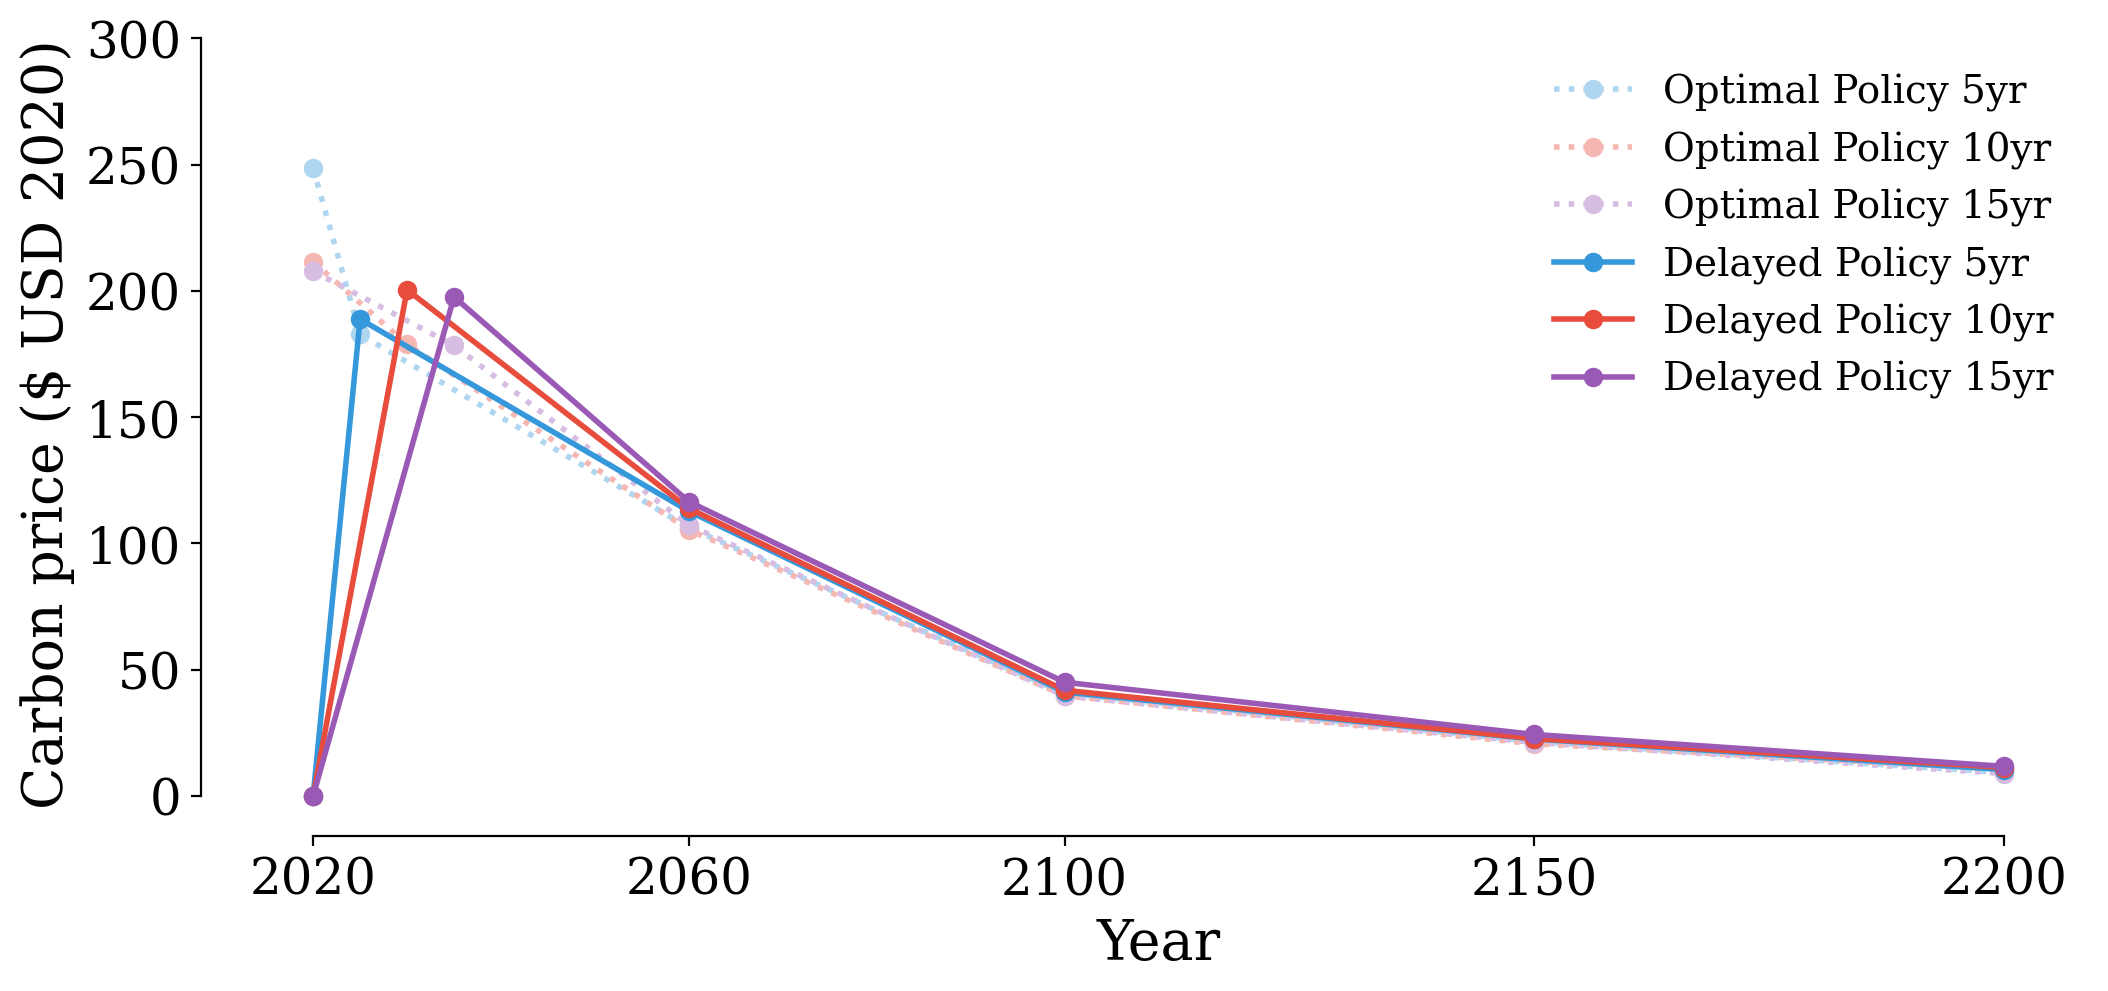

In [7]:
fig, ax = plt.subplots(1, figsize=(12,5))

for file in range(0, N_files):
    ax.plot(node_parent[file], np.mean(output_obj_list[file].price_path, axis=0), 
                  color=color_list[file], marker='o', 
                  label=pickle_obj_list[file].description[file], markersize=markersize,
                  linestyle=linestyle_list[file], linewidth=linewidth)


ax.set_ylabel("Carbon price ($ USD 2020)")
ax.legend(frameon=False)
ax.set_xlabel(x_label)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim((-5,300))
ax.set_yticks([0,50, 100,150, 200, 250, 300])
ax.set_xticks([2020, 2060, 2100, 2150, 2200])
sns.despine(trim=True, offset=10)

if SAVE_FIGURES:
    fig.savefig(''.join([basefile, fig_filename_prefix, '-cost.png']), dpi=400)

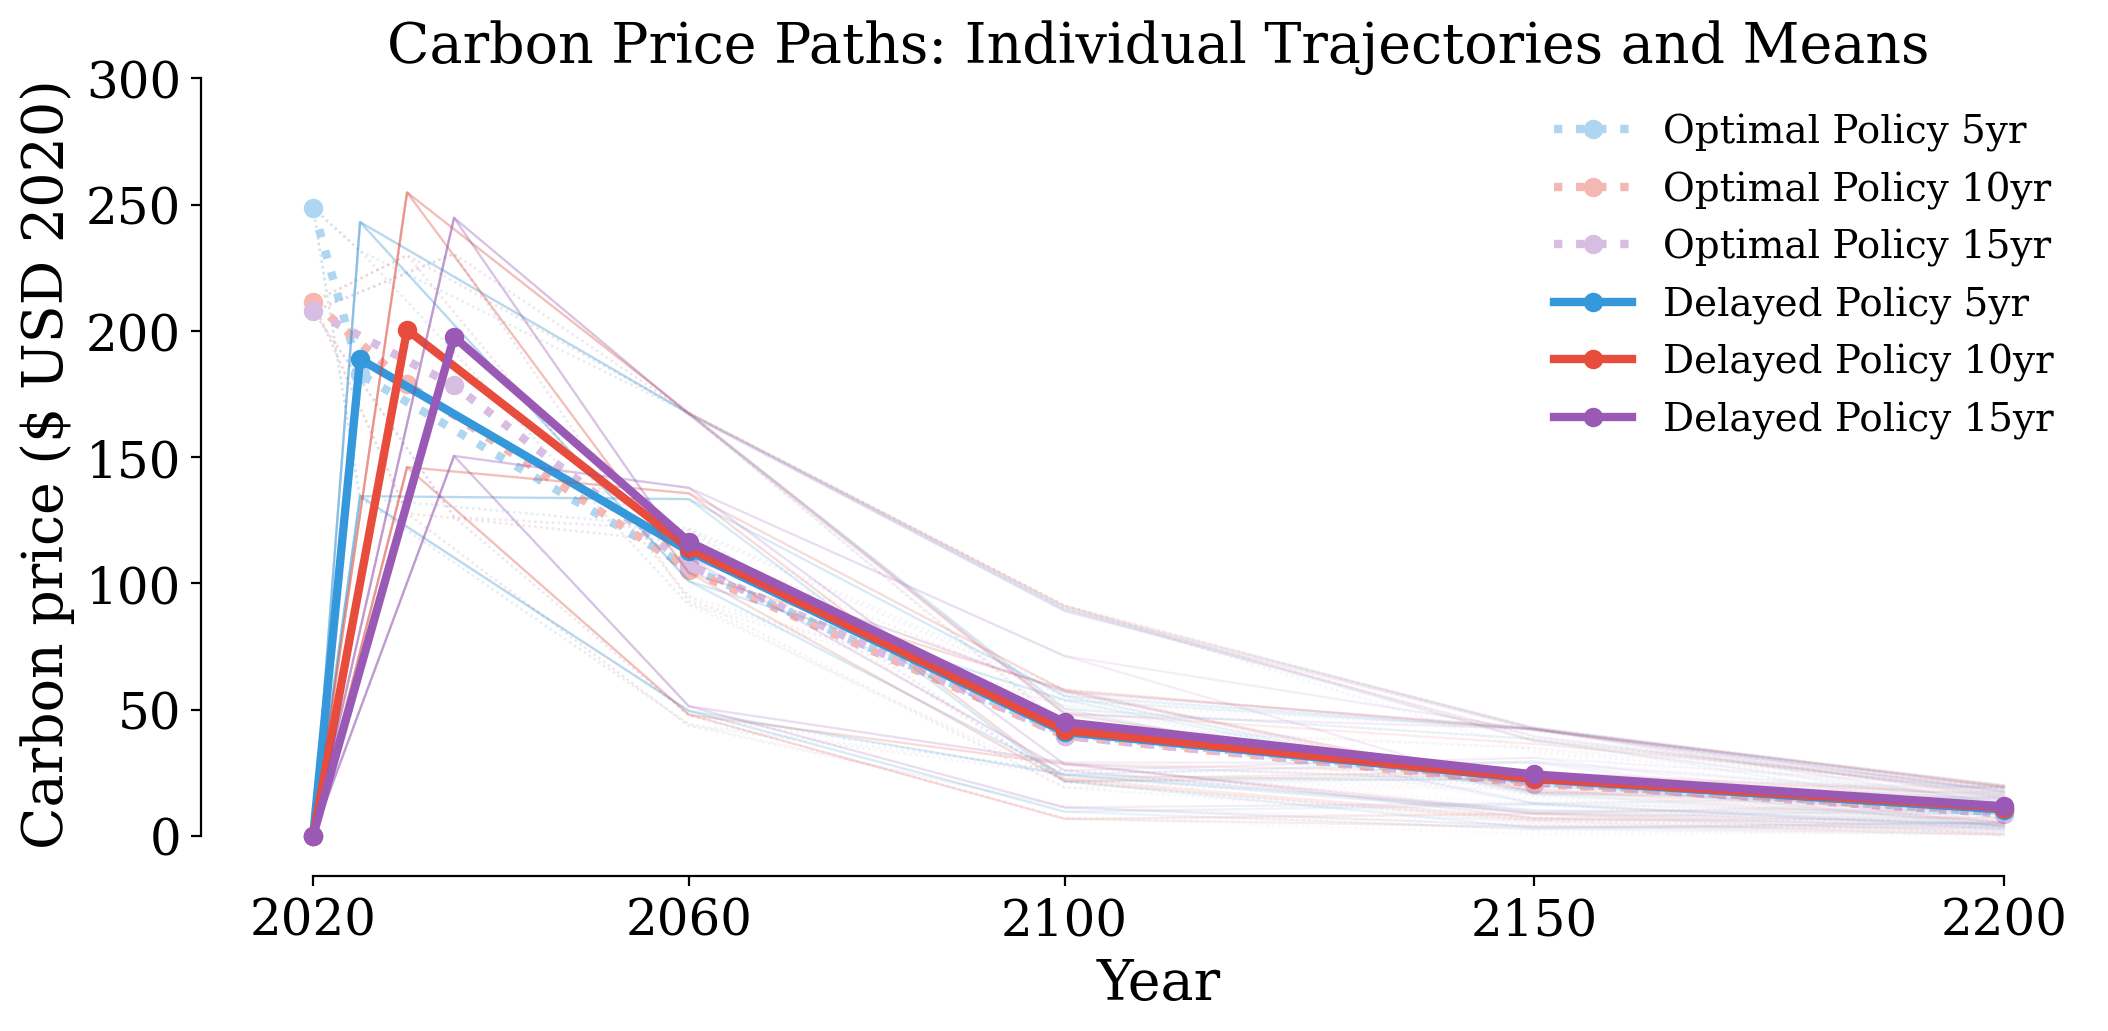

In [8]:
fig, ax = plt.subplots(1, figsize=(12,5))

# Plot all individual paths with transparency, then highlight the mean
for file in range(0, N_files):
    # Get all paths for this scenario
    price_paths = output_obj_list[file].price_path
    
    # Plot each individual path with transparency
    for path_idx in range(price_paths.shape[0]):
        ax.plot(node_parent[file], price_paths[path_idx, :], 
                color=color_list[file], 
                alpha=0.05,  # Make individual paths transparent
                linewidth=0.8,
                linestyle=linestyle_list[file])
    
    # Plot the mean path with full opacity and thicker line
    mean_path = np.mean(price_paths, axis=0)
    ax.plot(node_parent[file], mean_path, 
            color=color_list[file], 
            marker='o', 
            label=pickle_obj_list[file].description[file], 
            markersize=markersize,
            linestyle=linestyle_list[file], 
            linewidth=linewidth*1.5,  # Make mean line thicker
            alpha=1.0)  # Full opacity for mean

ax.set_ylabel("Carbon price ($ USD 2020)")
ax.legend(frameon=False)
ax.set_xlabel(x_label)
ax.set_title("Carbon Price Paths: Individual Trajectories and Means")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim((-5,300))
ax.set_yticks([0,50, 100,150, 200, 250, 300])
ax.set_xticks([2020, 2060, 2100, 2150, 2200])
sns.despine(trim=True, offset=10)

if SAVE_FIGURES:
    fig.savefig(''.join([basefile, fig_filename_prefix, '-cost-all-paths.png']), dpi=400)

Average mitigation

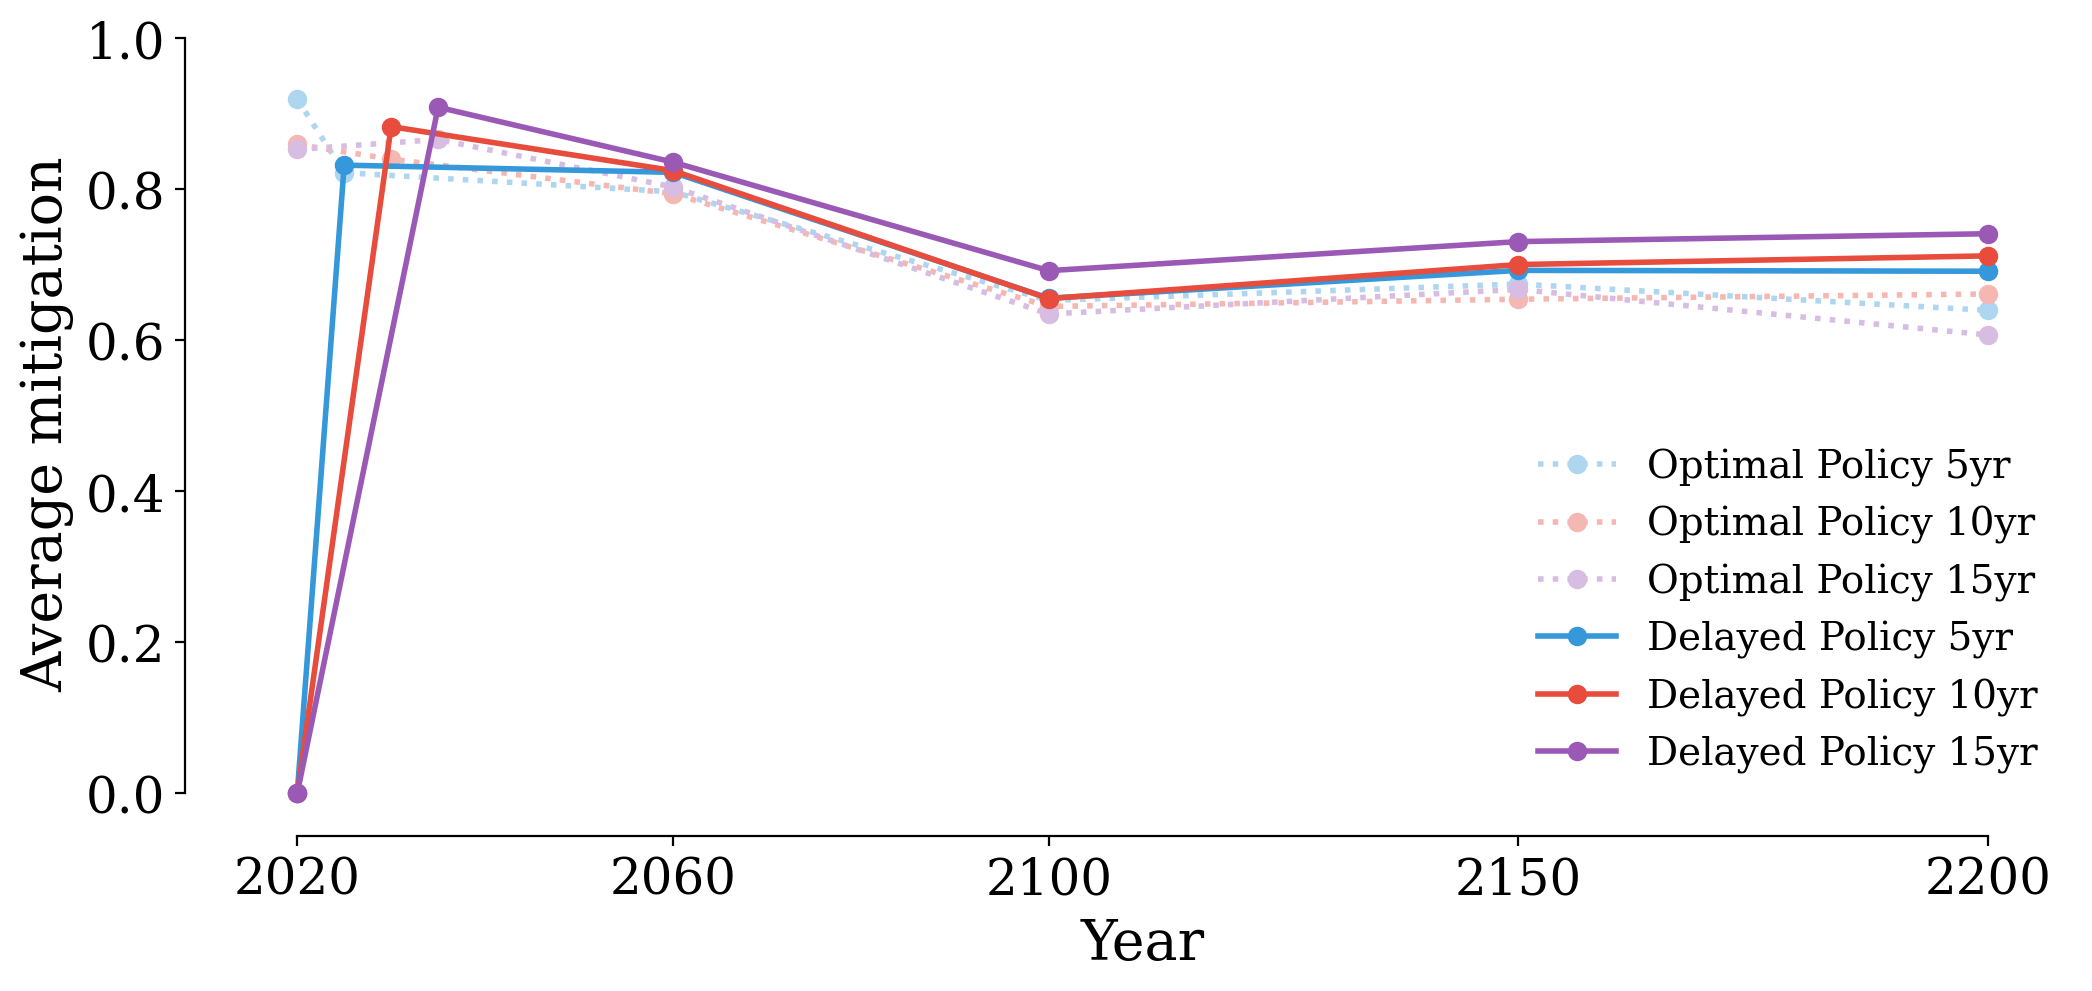

In [9]:
fig, ax = plt.subplots(1, figsize=(12,5))

for file in range(0, N_files):
    ax.plot(node_parent[file], np.mean(pickle_obj_list[file].m_opt_path, axis=0), 
            color=color_list[file], marker='o', 
            label=pickle_obj_list[file].description[file], markersize=markersize,
            linestyle=linestyle_list[file], linewidth=linewidth)

ax.set_ylabel("Average mitigation")
ax.legend(frameon=False)
ax.set_xlabel(x_label)
ax.tick_params(axis='both')
#ax.axhline(1, color='g', linestyle='dashed')
ax.set_ylim((-0.02,1.0))
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks([2020, 2060, 2100, 2150, 2200])
sns.despine(trim=True, offset=10)

if SAVE_FIGURES:
    fig.savefig(''.join([basefile, fig_filename_prefix, '-mit.png']), dpi=400)

#### Expected mitigation

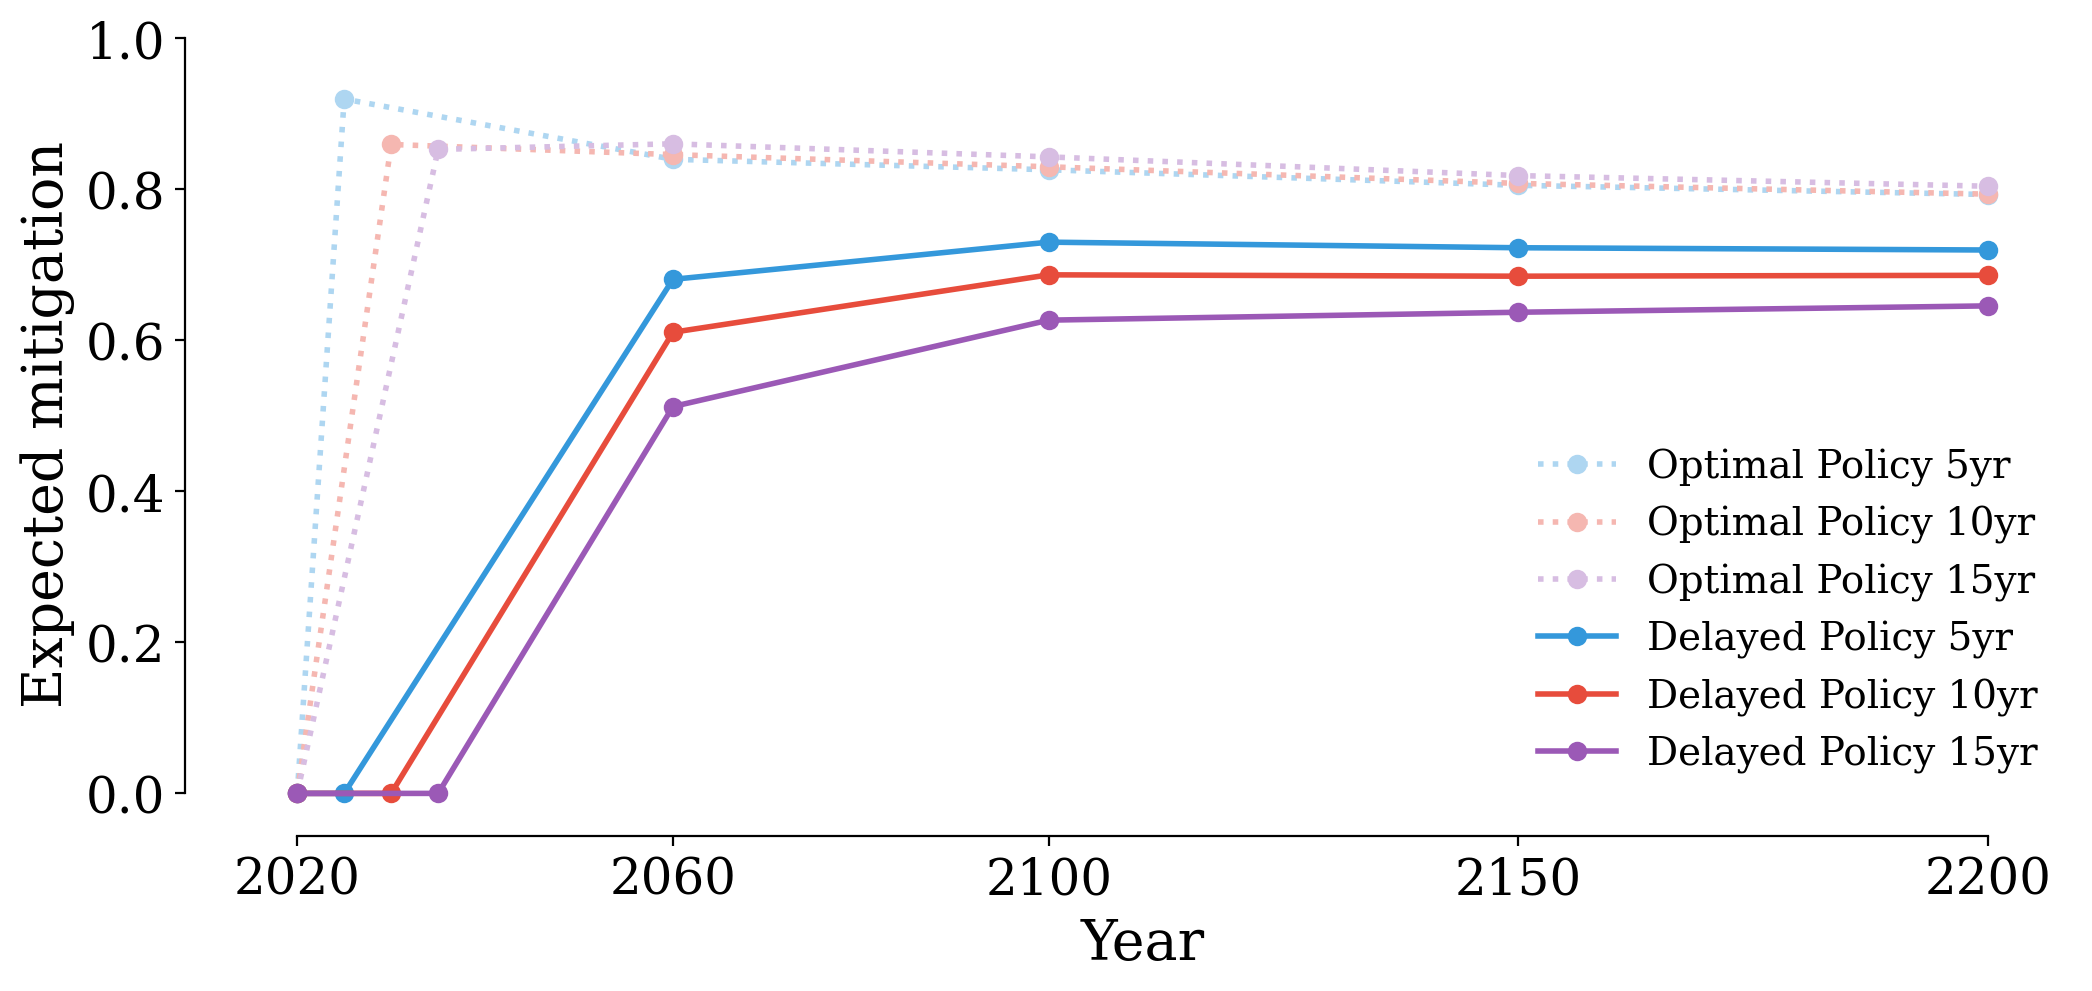

In [10]:
fig, ax = plt.subplots(1, figsize=(12,5))

for file in range(0, N_files):
    ax.plot(node_parent[file], np.mean(output_obj_list[file].exp_mit_path, axis=0), 
            color=color_list[file], marker='o', 
            label=pickle_obj_list[file].description[file], markersize=markersize,
            linestyle=linestyle_list[file], linewidth=linewidth)

ax.set_ylabel("Expected mitigation")
ax.legend(frameon=False)
ax.set_xlabel(x_label)
#ax.axhline(1, color='g', linestyle='dashed')
ax.set_ylim((-0.02,1.0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([2020, 2060, 2100, 2150, 2200])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
sns.despine(trim=True, offset=10)

if SAVE_FIGURES:
    fig.savefig(''.join([basefile, fig_filename_prefix, '-exp-mit.png']), dpi=400)

### (Mitigated) emissions

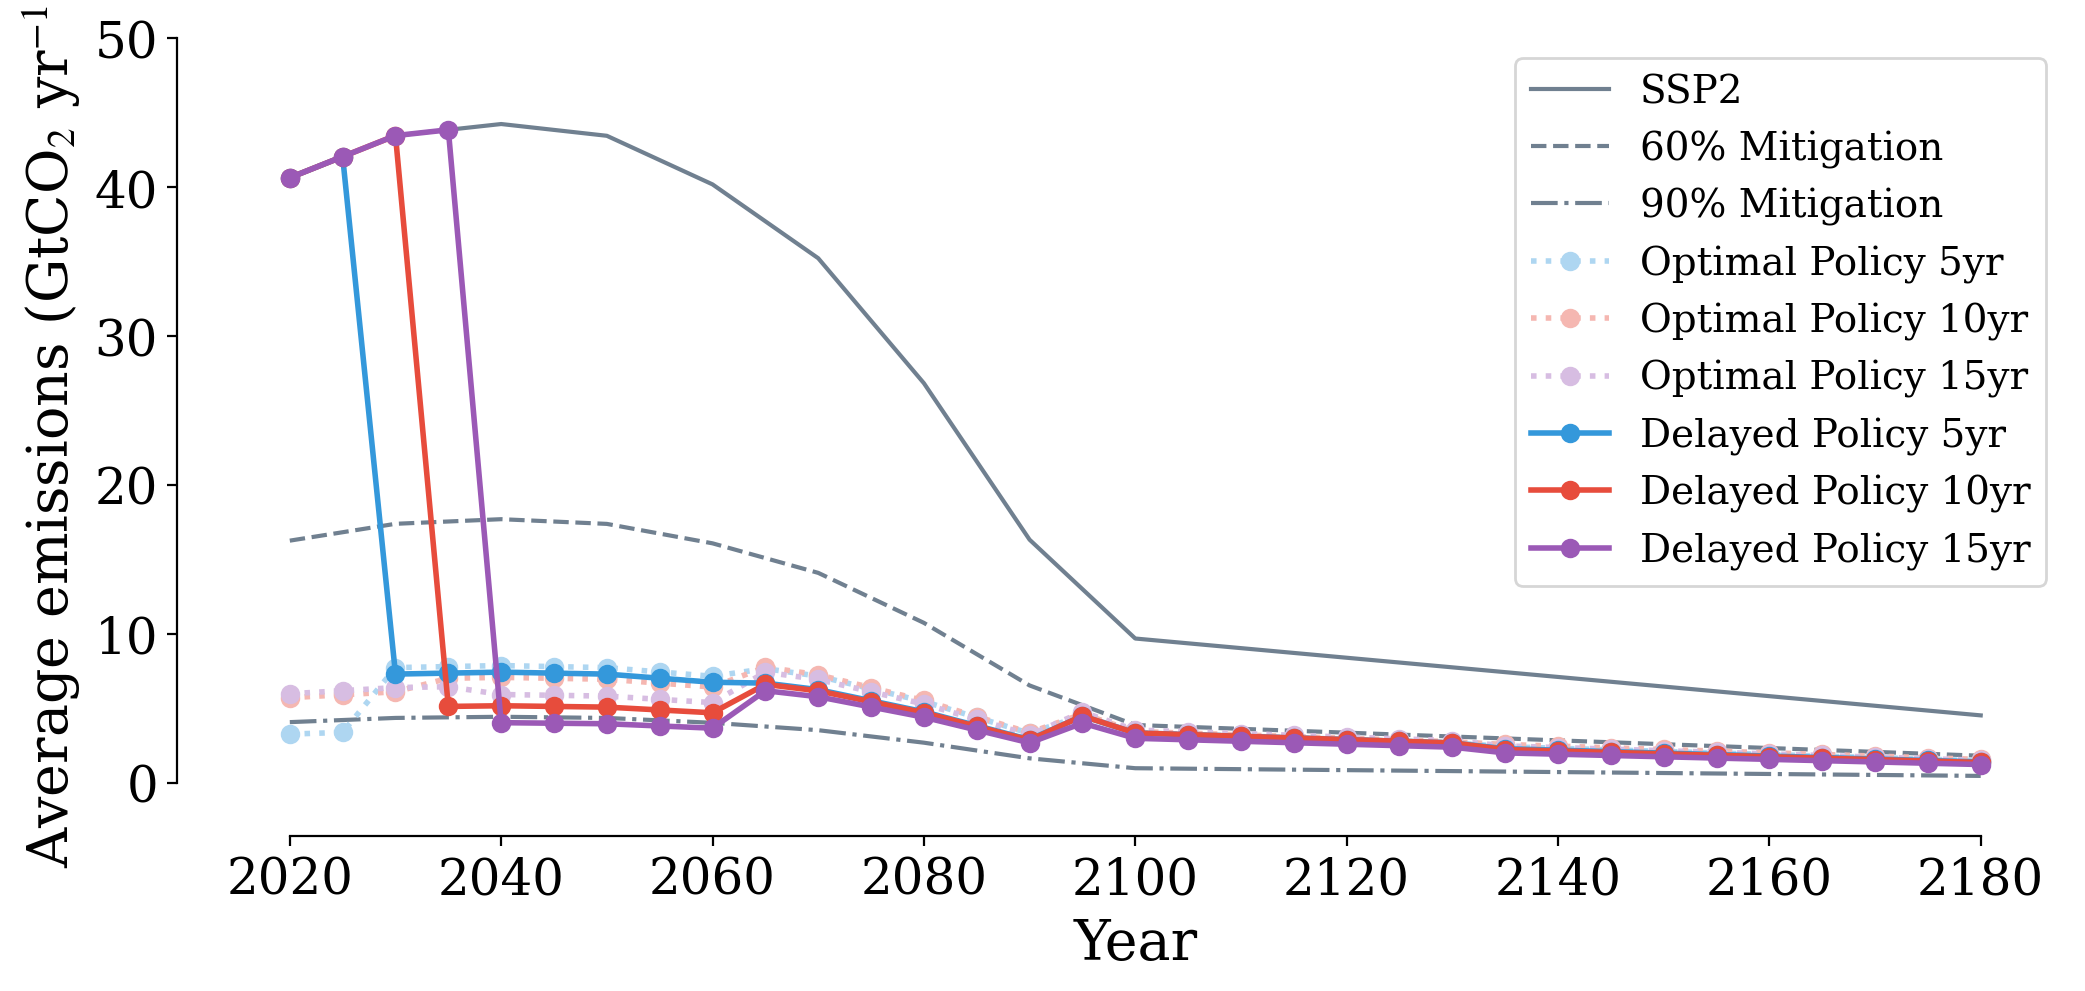

In [11]:
fig, ax = plt.subplots(1, figsize=(12,5))

ax.plot(tmp_baseline_emission_model.times[:-10], tmp_baseline_emission_model.baseline_gtco2[:-10], 
        color='slategrey', label="SSP2")
ax.plot(tmp_baseline_emission_model.times[:-10], (1 - 0.6) * tmp_baseline_emission_model.baseline_gtco2[:-10], 
        color='slategrey', label="60% Mitigation", linestyle="dashed")
ax.plot(tmp_baseline_emission_model.times[:-10], (1 - 0.9) * tmp_baseline_emission_model.baseline_gtco2[:-10], 
        color='slategrey', label="90% Mitigation", linestyle="dashdot")

for file in range(0, N_files):
    # Use the minimum length between the times array and emissions array for this specific file
    n_times = len(models[file]['emit_baseline'].times)
    n_emis = len(pickle_obj_list[file].emis_gtco2_full.mean(axis=0))
    n_plot = min(n_times, n_emis)
    
    ax.plot(models[file]['emit_baseline'].times[:n_plot], 
            np.mean(pickle_obj_list[file].emis_gtco2_full, axis=0)[:n_plot], 
            color=color_list[file], marker='o', 
            label=pickle_obj_list[file].description[file], markersize=markersize,
            linestyle=linestyle_list[file], linewidth=linewidth)

    
ax.set_ylabel("Average emissions (GtCO$_2$ yr$^{-1}$)")
ax.set_yticks([0, 10, 20, 30, 40, 50])
ax.set_xlabel(x_label)
sns.despine(trim=True, offset=10)
ax.legend()

### Average temperature

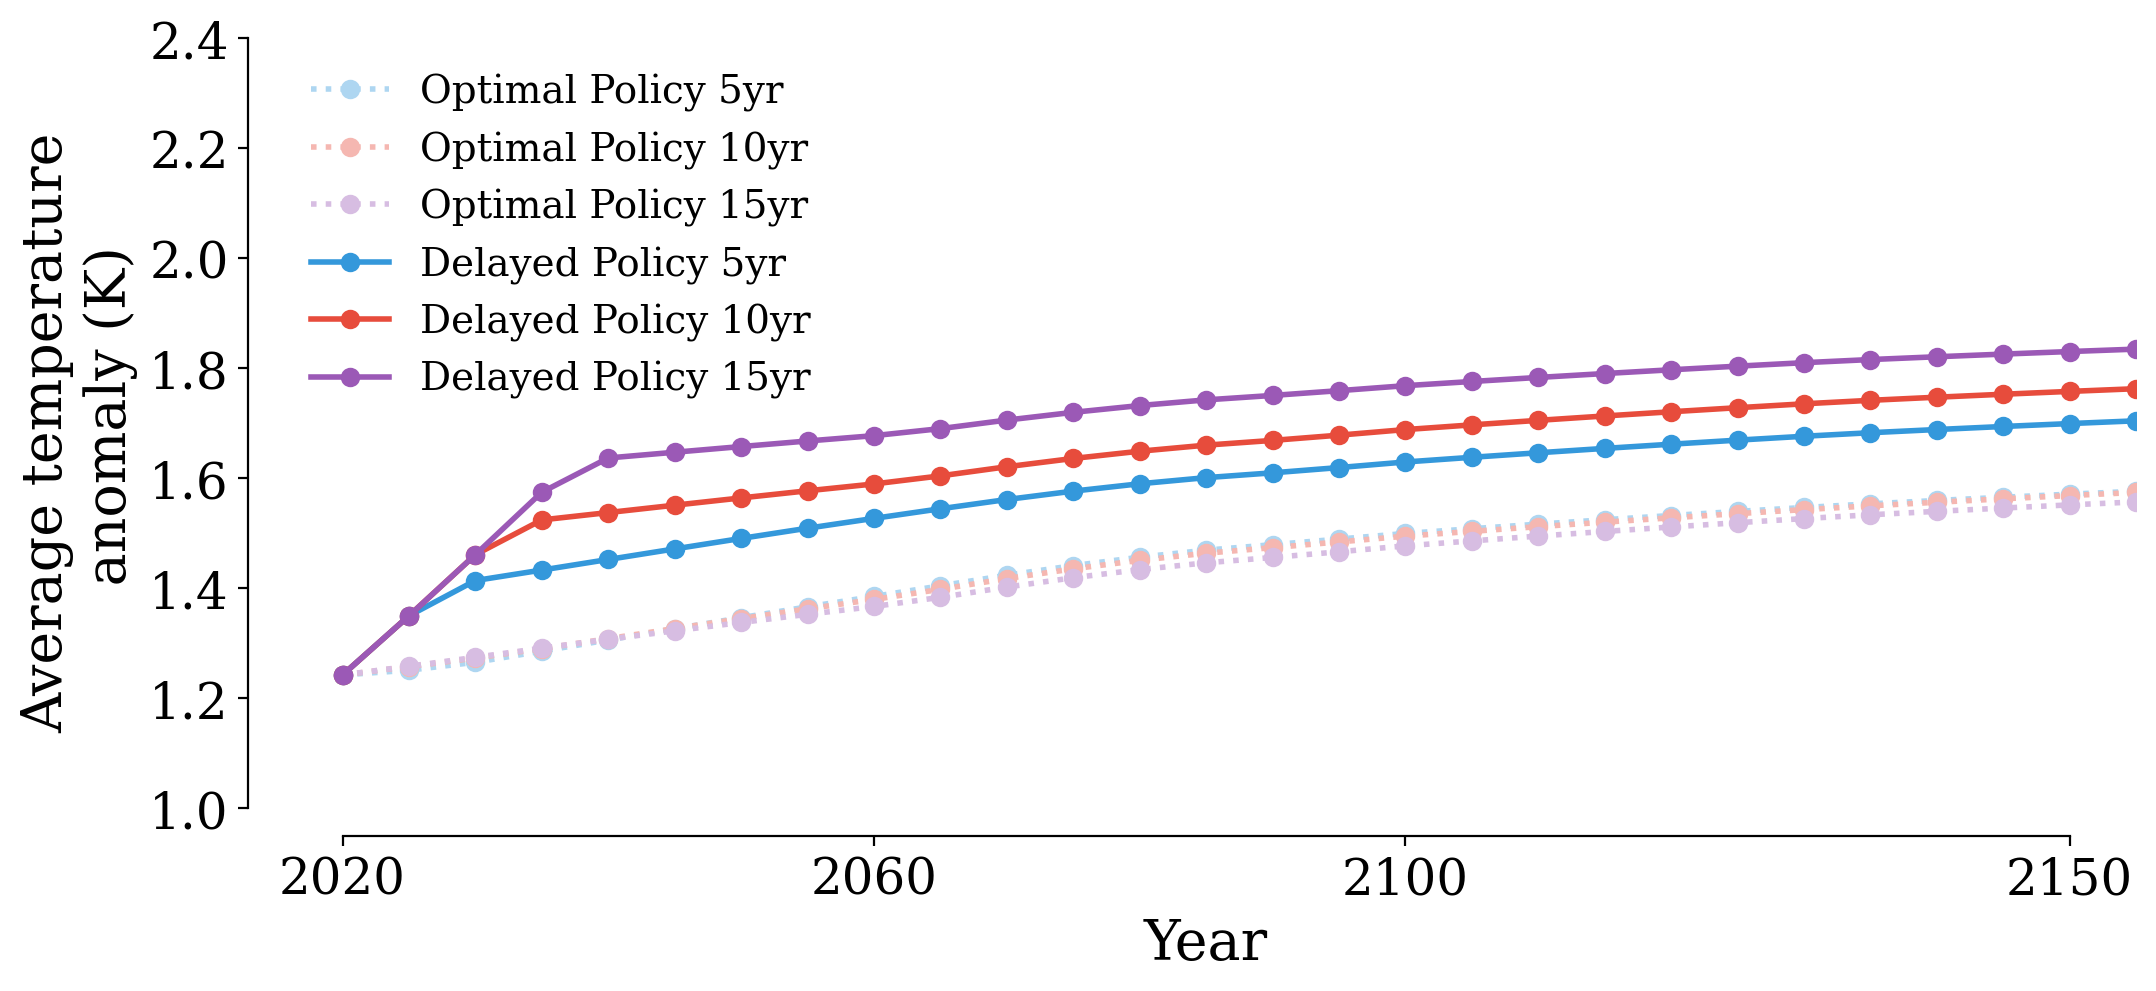

In [12]:
fig, ax = plt.subplots(1, figsize=(12,5))

trigger = 2  # Reduced to show more data

for file in range(0, N_files):
    # Use the minimum length between the times array and temperature array for this specific file
    n_times = len(models[file]['emit_baseline'].times)
    n_temp = len(pickle_obj_list[file].temp_full.mean(axis=0))
    n_plot = min(n_times, n_temp) - trigger
    
    ax.plot(models[file]['emit_baseline'].times[:n_plot], 
            np.mean(pickle_obj_list[file].temp_full, axis=0)[:n_plot], 
            color=color_list[file], marker='o', 
            label=pickle_obj_list[file].description[file], markersize=markersize,
            linestyle=linestyle_list[file], linewidth=linewidth)

    
ax.set_ylabel("Average temperature \n anomaly (K)")
ax.legend(frameon=False)
ax.set_xlabel(x_label)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([2020, 2060, 2100, 2150])
ax.set_xlim((2015, 2155))
ax.set_yticks([1, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
sns.despine(trim=True, offset=10)

if SAVE_FIGURES:
    fig.savefig(''.join([basefile, fig_filename_prefix, '-temp.png']), dpi=400)

#### Avg. temperature

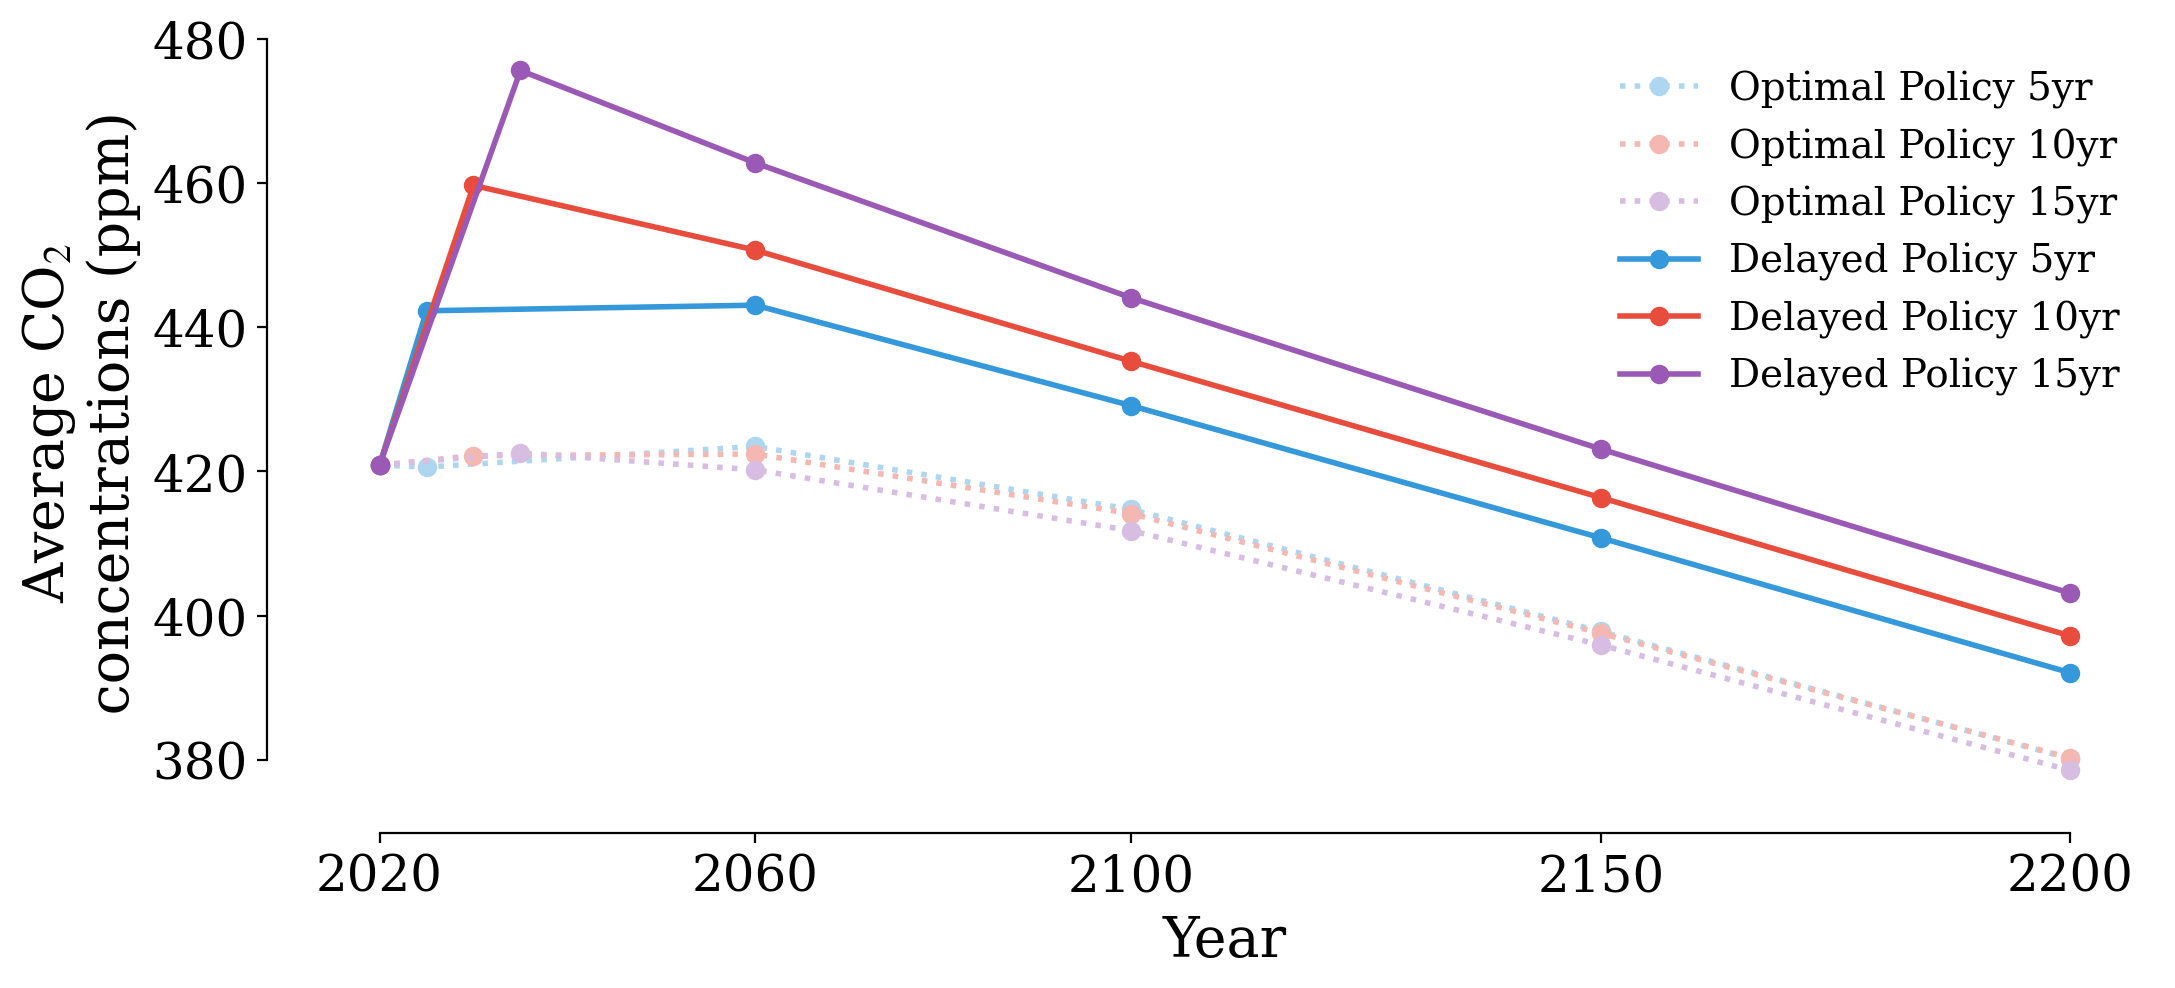

In [13]:
fig, ax = plt.subplots(1, figsize=(12,5))

for file in range(0, N_files):
    ax.plot(node_parent[file], np.mean(output_obj_list[file].ghg_lvl_path, axis=0), 
                  color=color_list[file], marker='o', 
                  label=pickle_obj_list[file].description[file], markersize=markersize,
                  linestyle=linestyle_list[file], linewidth=linewidth)


ax.set_ylabel("Average CO$_2$ \n concentrations (ppm)")
ax.legend(frameon=False)
ax.set_xlabel(x_label)
ax.set_xticks([2020, 2060, 2100, 2150, 2200])
sns.despine(trim=True, offset=10)

if SAVE_FIGURES:
    fig.savefig(''.join([basefile, fig_filename_prefix, '-co2.png']), dpi=400)

### Economic damages

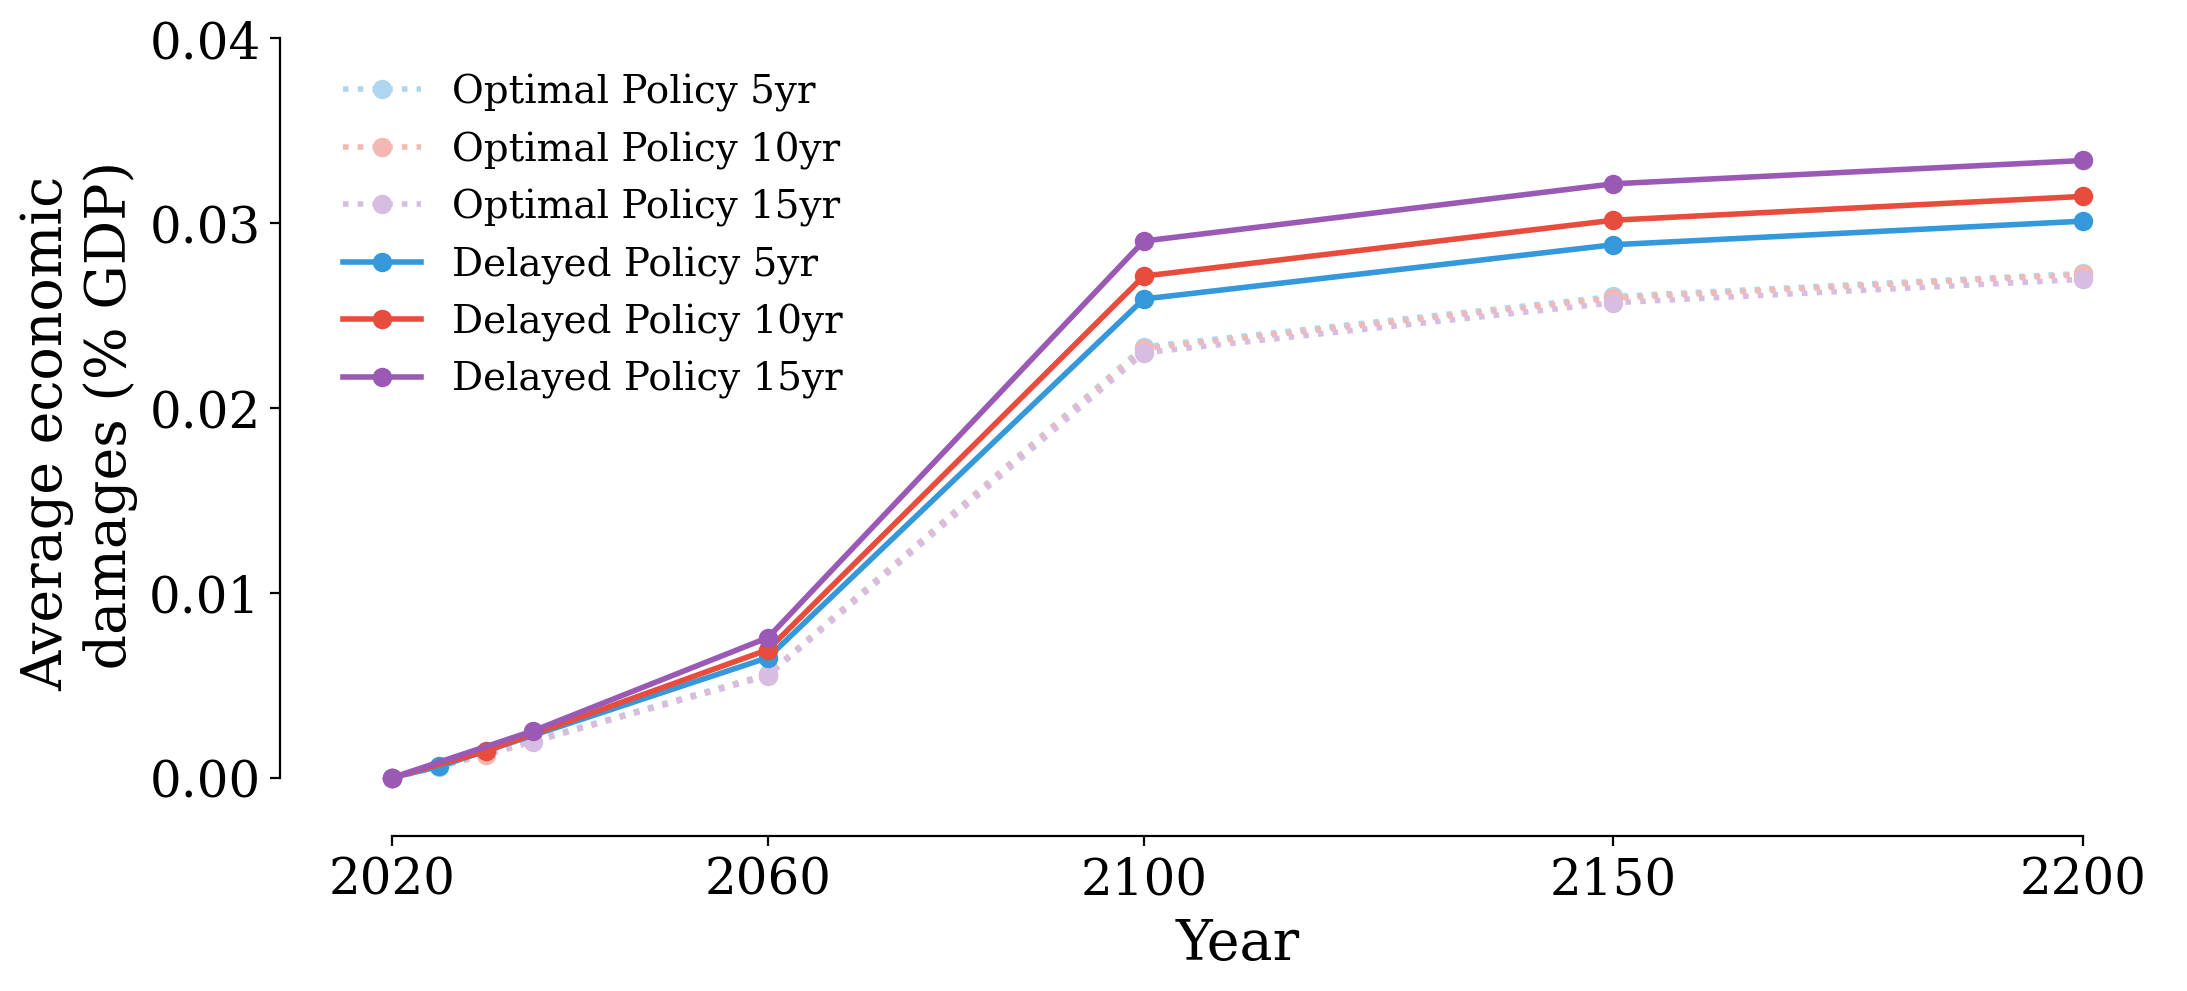

In [14]:
fig, ax = plt.subplots(1, figsize=(12,5))

for file in range(0, N_files):
    ax.plot(node_parent[file], np.mean(pickle_obj_list[file].econ_dam_path, axis=0), 
                  color=color_list[file], marker='o', 
                  label=pickle_obj_list[file].description[file], markersize=markersize,
                  linestyle=linestyle_list[file], linewidth=linewidth)

ax.set_ylabel("Average economic \n damages (% GDP)")
ax.legend(frameon=False)
ax.set_xlabel(x_label)
ax.set_xticks([2020, 2060, 2100, 2150, 2200])
ax.set_yticks([0.00, 0.01, 0.02, 0.03, 0.04])
sns.despine(trim=True, offset=10)
plt.show()


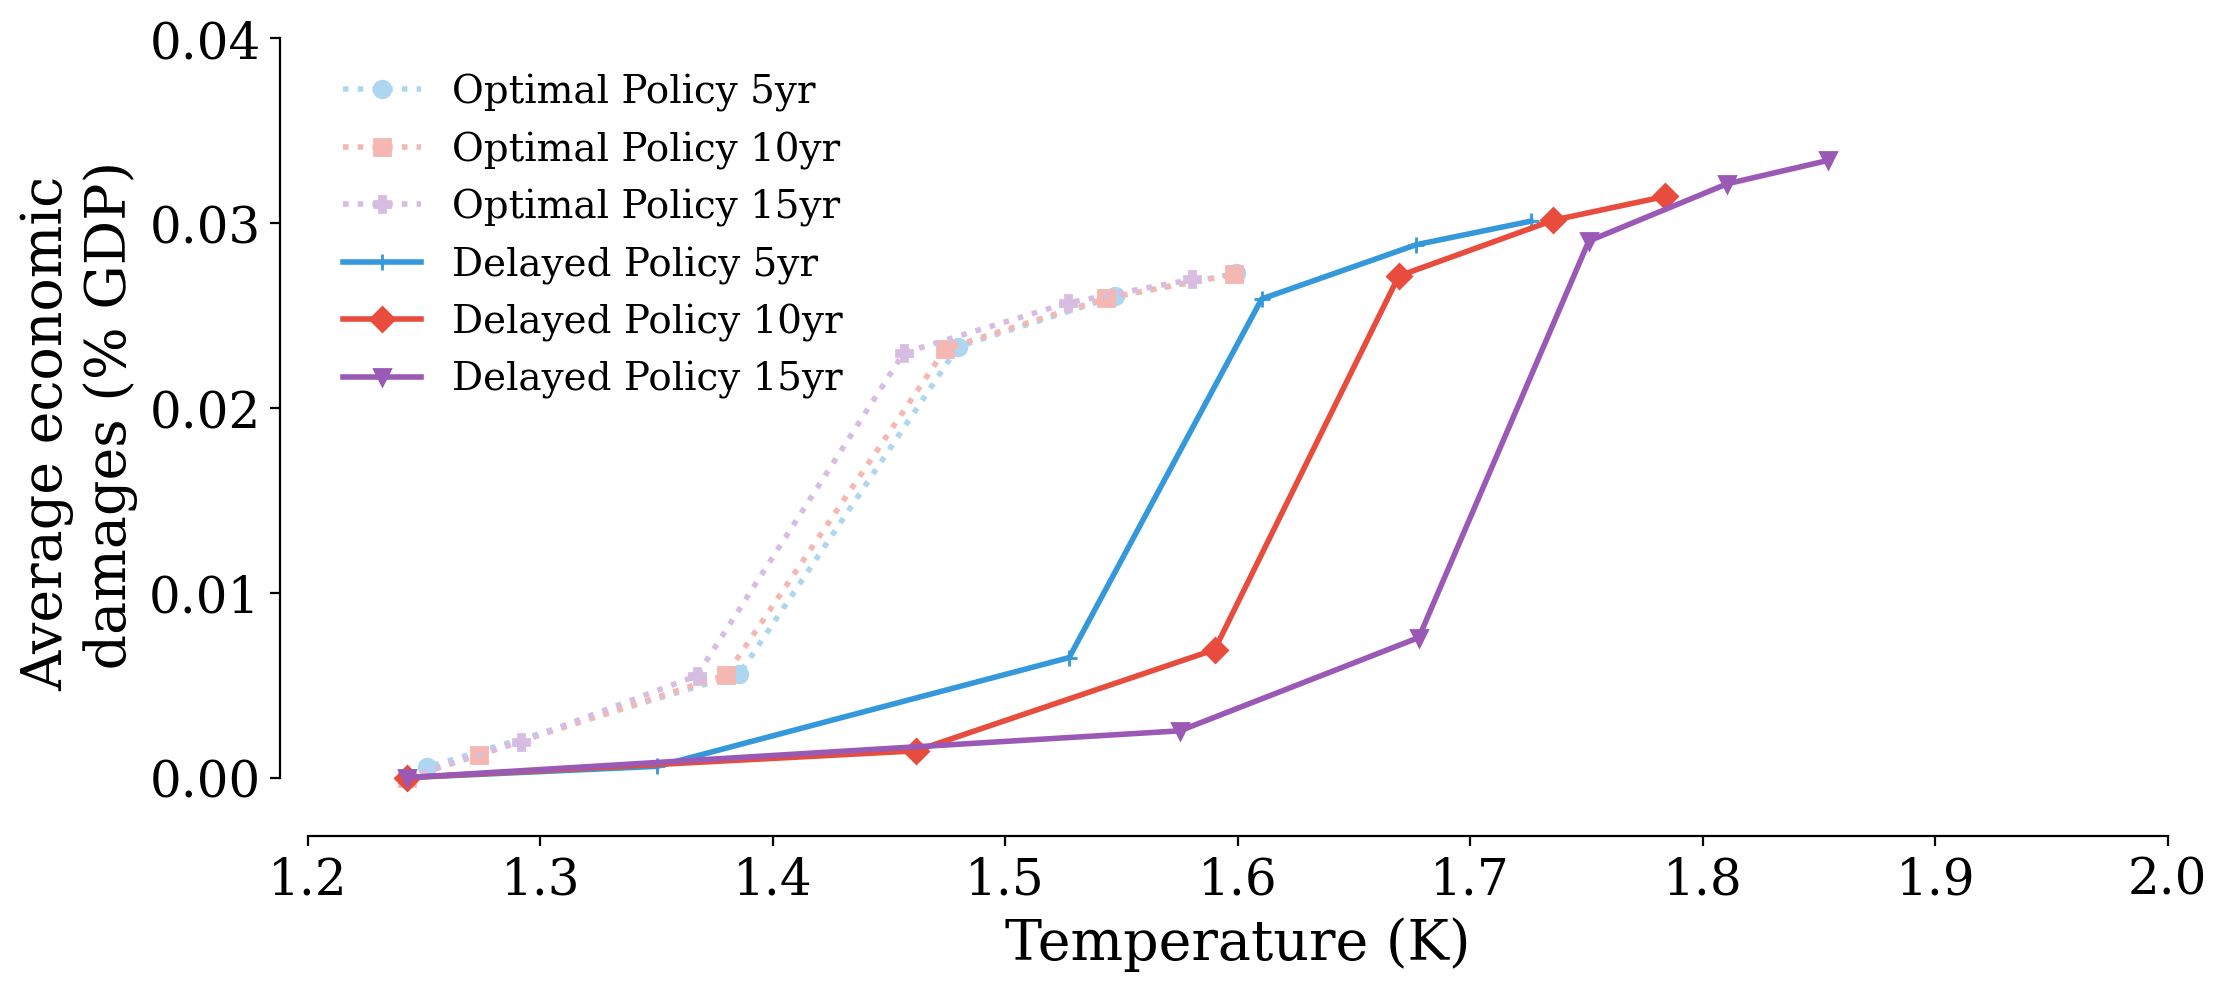

In [15]:
fig, ax = plt.subplots(1, figsize=(12,5))

for file in range(0, N_files):
    ax.plot(np.mean(pickle_obj_list[file].temp_path, axis=0), np.mean(pickle_obj_list[file].econ_dam_path, axis=0), 
                  color=color_list[file], marker=marker_list[file], 
                  label=pickle_obj_list[file].description[file], markersize=markersize,
                  linestyle=linestyle_list[file], linewidth=linewidth)

ax.set_ylabel("Average economic \n damages (% GDP)")
ax.legend(frameon=False)
ax.set_xlabel("Temperature (K)")
ax.set_xlim((1.2, 2.0))
ax.set_yticks([0.00, 0.01, 0.02, 0.03, 0.04])
sns.despine(trim=True, offset=10)
plt.show()


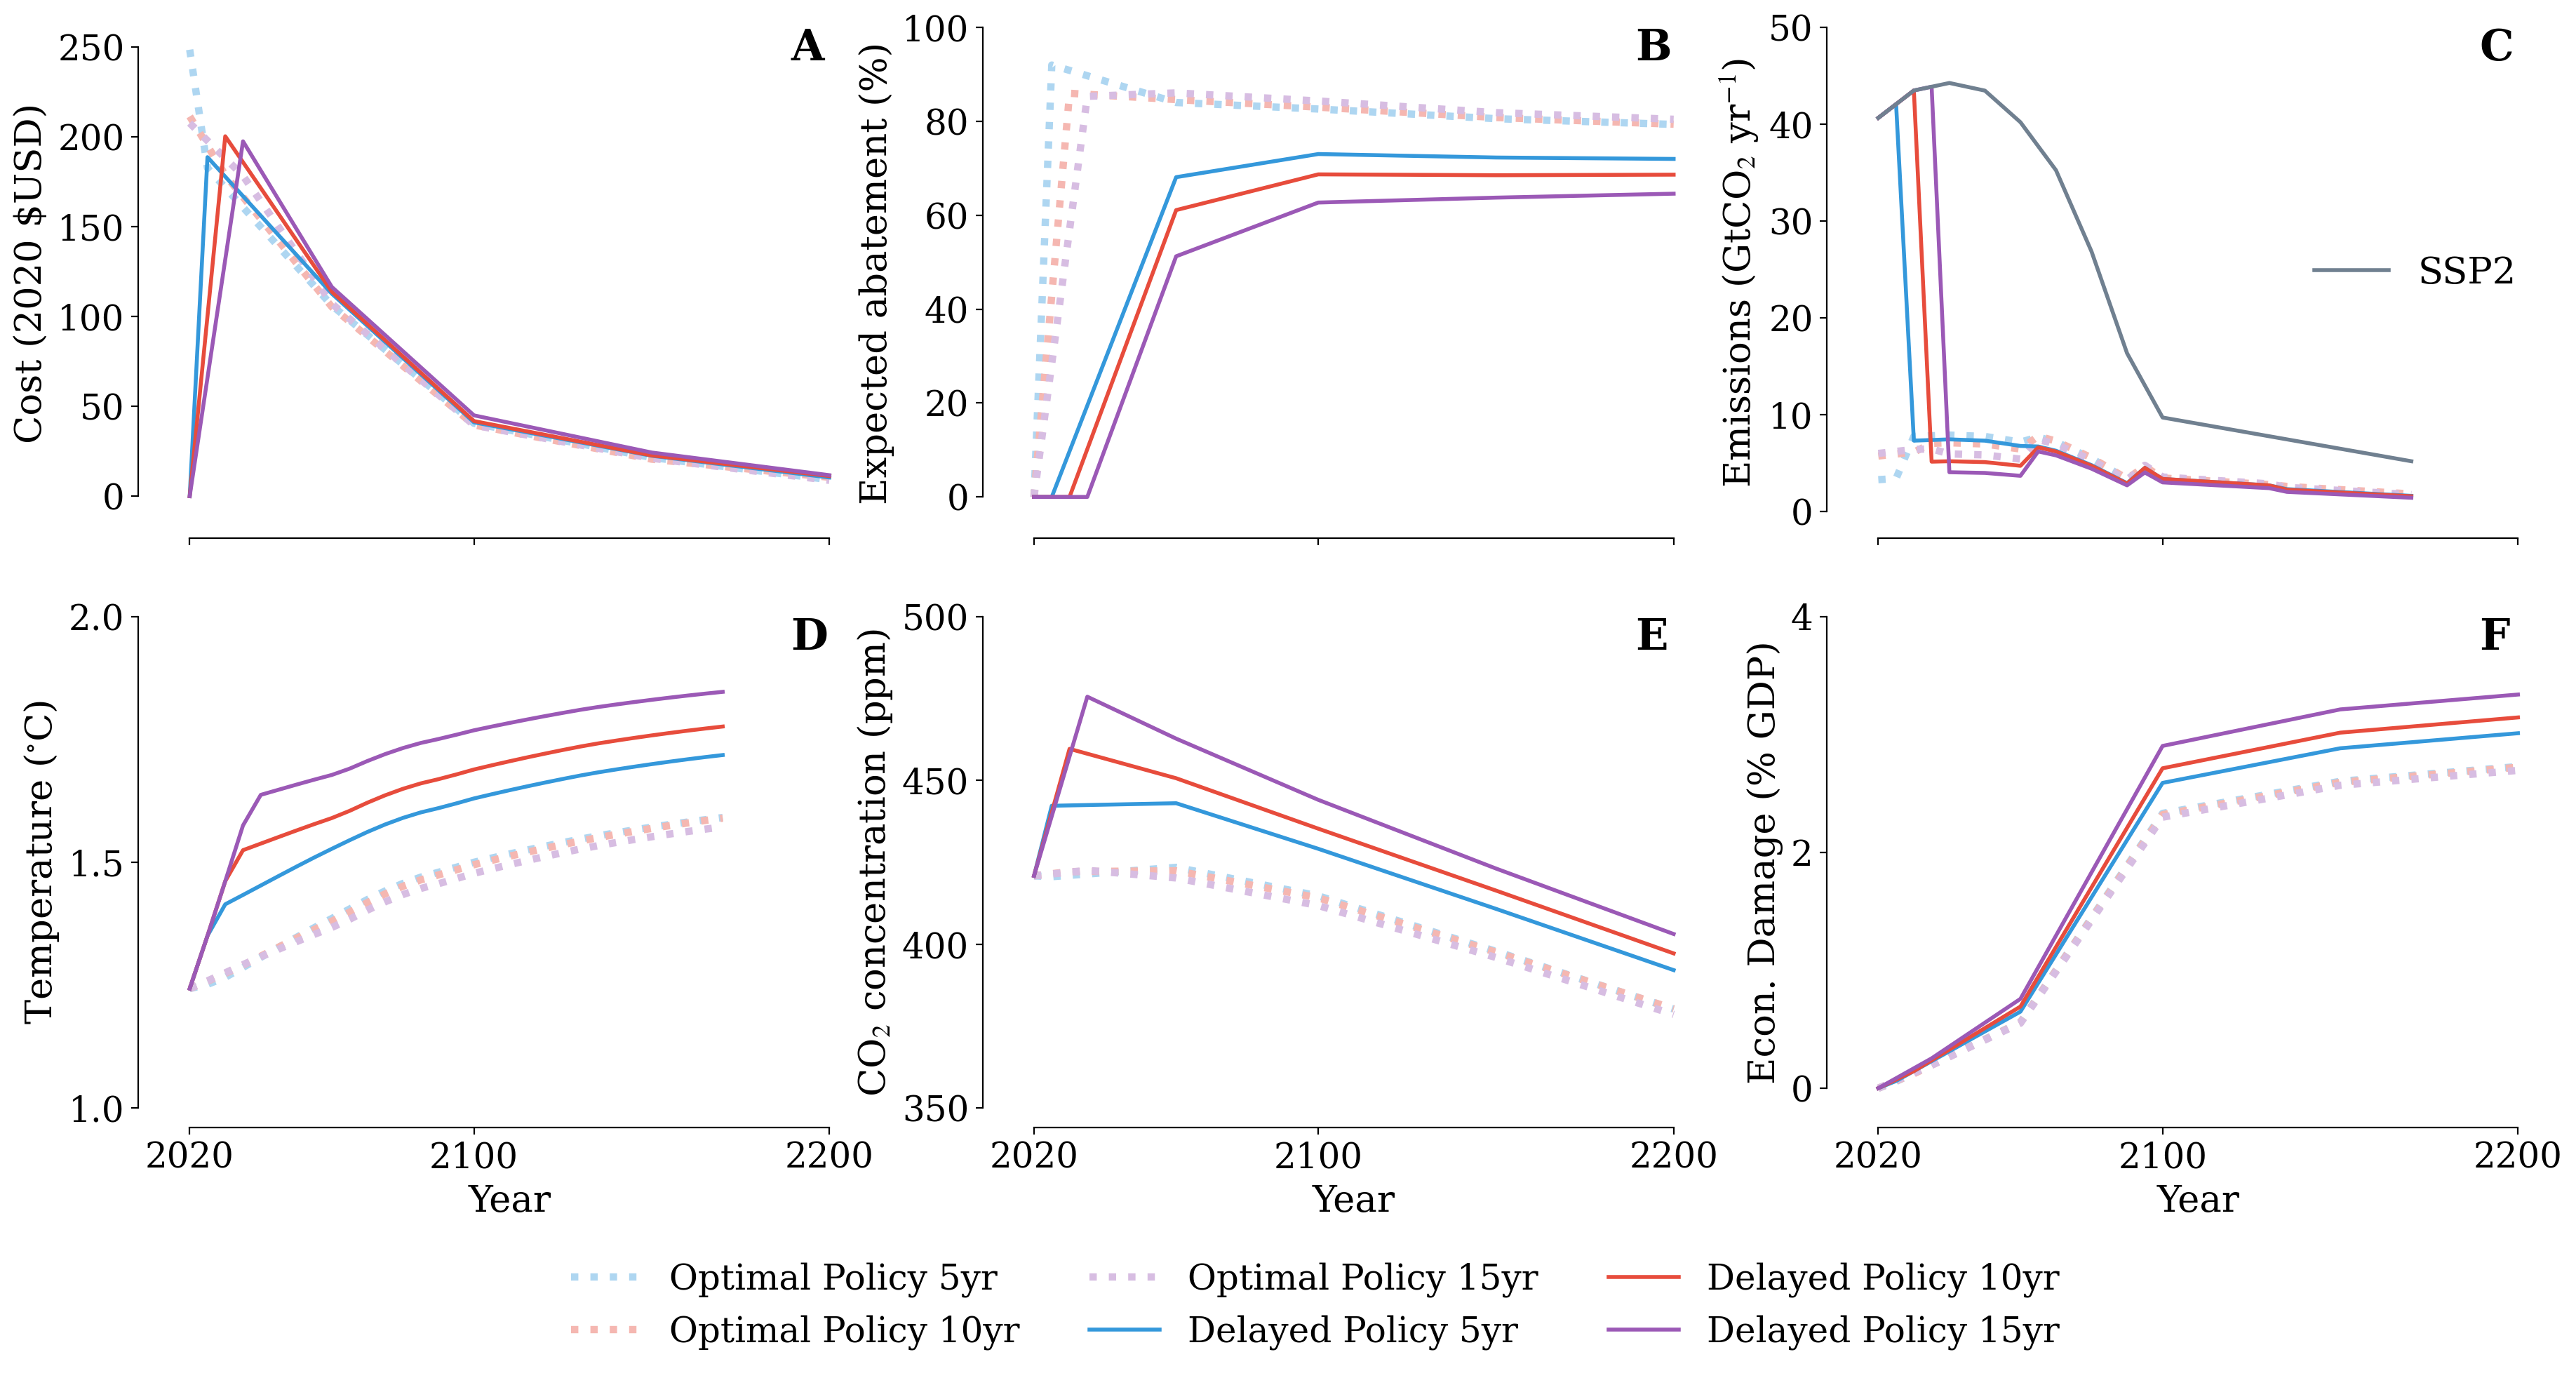

In [16]:
import matplotlib.transforms as mtransforms

fig, ax = plt.subplot_mosaic([['A', 'B', 'C'], ['D', 'E', 'F']], sharex=True,
                             gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1, 1]},
                            figsize=(22,10))

pref_lw = 3.75
feat_lw = 2
trigger = 2  # Reduced to show more data

# Plot all 6 scenarios
for file in range(N_files):
    lw = pref_lw if file < 3 else feat_lw  # First 3 are optimal (thicker), last 3 are delayed (thinner)
    
    # Panel A: Price path
    ax['A'].plot(node_parent[file], np.mean(output_obj_list[file].price_path, axis=0), 
                  color=color_list[file], 
                  label=descriptions[file],
                  linestyle=linestyle_list[file], linewidth=lw)
    
    # Panel B: Expected mitigation
    ax['B'].plot(node_parent[file], np.mean(output_obj_list[file].exp_mit_path, axis=0) * 100, 
                  color=color_list[file], 
                  label=descriptions[file],
                  linestyle=linestyle_list[file], linewidth=lw)
    
    # Panel C: Emissions - use file-specific array lengths
    n_times_c = len(models[file]['emit_baseline'].times)
    n_emis_c = len(pickle_obj_list[file].emis_gtco2_full.mean(axis=0))
    n_plot_c = min(n_times_c, n_emis_c) - trigger
    
    ax['C'].plot(models[file]['emit_baseline'].times[:n_plot_c], 
                  np.mean(pickle_obj_list[file].emis_gtco2_full, axis=0)[:n_plot_c], 
                  color=color_list[file], 
                  linestyle=linestyle_list[file], linewidth=lw)
    
    # Panel D: Temperature - use file-specific array lengths
    n_times_d = len(models[file]['emit_baseline'].times)
    n_temp_d = len(pickle_obj_list[file].temp_full.mean(axis=0))
    n_plot_d = min(n_times_d, n_temp_d) - trigger
    
    ax['D'].plot(models[file]['emit_baseline'].times[:n_plot_d], 
                  np.mean(pickle_obj_list[file].temp_full, axis=0)[:n_plot_d], 
                  color=color_list[file], 
                  label=descriptions[file],
                  linestyle=linestyle_list[file], linewidth=lw)
    
    # Panel E: GHG level
    ax['E'].plot(node_parent[file], np.mean(output_obj_list[file].ghg_lvl_path, axis=0), 
                  color=color_list[file], 
                  label=descriptions[file],
                  linestyle=linestyle_list[file], linewidth=lw)
    
    # Panel F: Economic damage
    ax['F'].plot(node_parent[file], np.mean(pickle_obj_list[file].econ_dam_path * 100, axis=0), 
                  color=color_list[file], 
                  label=descriptions[file],
                  linestyle=linestyle_list[file], linewidth=lw)

# Plot SSP2 baseline for clarity
ax['C'].plot(tmp_baseline_emission_model.times[:-12], tmp_baseline_emission_model.baseline_gtco2[:-12], 
        color='slategrey', label="SSP2", linewidth=feat_lw)
ax['C'].legend(loc='right', fontsize=19, frameon=False)

panels = ['A', 'B', 'C', 'D', 'E', 'F']
for panel in panels:
    ax[panel].set_xticks([2020, 2100, 2200])

# Set ticks
ax['A'].set_yticks([0, 50, 100, 150, 200, 250])
ax['B'].set_yticks([0, 20, 40, 60, 80, 100])
ax['C'].set_yticks([0, 10, 20, 30, 40, 50])
ax['D'].set_yticks([1, 1.5, 2,])
ax['E'].set_yticks([350, 400, 450, 500])
ax['F'].set_yticks([0, 2, 4])

# Set labels
ax['A'].set_ylabel("Cost (2020 $USD)", fontsize=19)
ax['B'].set_ylabel("Expected abatement (%)", fontsize=19)
ax['C'].set_ylabel("Emissions (GtCO$_2$ yr$^{-1}$)", fontsize=19)
ax['D'].set_ylabel("Temperature ($^{\circ}$C)", fontsize=19)
ax['E'].set_ylabel("CO$_2$ concentration (ppm)", fontsize=19)
ax['F'].set_ylabel("Econ. Damage (% GDP)", fontsize=19)

ax['D'].set_xlabel("Year", fontsize=19)
ax['E'].set_xlabel("Year", fontsize=19)
ax['F'].set_xlabel("Year", fontsize=19)

# Bottom legend with all 6 scenarios
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.085), 
           ncol=3, fancybox=True, frameon=False, fontsize=18, 
           labels=descriptions)

# Add panel labels
for label in panels:
    trans = mtransforms.ScaledTranslation(0, 0.0, fig.dpi_scale_trans)
    ax[label].text(0.9, 1.0, label, transform=ax[label].transAxes + trans, fontsize=22, fontweight='bold',
            verticalalignment='top', bbox=dict(facecolor='none', edgecolor='none', pad=1))
    
sns.despine(trim=True, offset=10)

if SAVE_FIGURES:
    fig.savefig(''.join([basefile, 'optimal-delayed-comparison.png']), bbox_inches='tight', dpi=400)


## Delay-to-Price Elasticity Analysis

Calculate $κ(L) = \partial log(\tau_L^{\mathrm{delay}})/\partial L$, the percent increase in carbon price at re-entry per year of delay.

In [17]:
delay_years_list = np.array([5, 10, 15])
n_delays = len(delay_years_list)

tau_optimal = np.zeros(n_delays)
tau_delayed = np.zeros(n_delays)
m_optimal = np.zeros(n_delays)
m_delayed = np.zeros(n_delays)

for i, L in enumerate(delay_years_list):
    optimal_idx = i      # Files 0, 1, 2
    delayed_idx = i + 3  # Files 3, 4, 5
    
    period_idx = 1
    reentry_year = 2020 + L
    optimal_times = [2020 + dt for dt in models[optimal_idx]['tree'].decision_times]
    delayed_times = [2020 + dt for dt in models[delayed_idx]['tree'].decision_times]
    
    print(f"\nDelay scenario L={L} years (re-entry at {reentry_year}):")
    print(f"  Optimal file {optimal_idx}: decision times = {optimal_times}")
    print(f"  Delayed file {delayed_idx}: decision times = {delayed_times}")
    print(f"  Both extract at period index {period_idx} (re-entry)")
    
    tau_optimal[i] = np.mean(output_obj_list[optimal_idx].price_path[:, period_idx])
    tau_delayed[i] = np.mean(output_obj_list[delayed_idx].price_path[:, period_idx])
    
    m_optimal[i] = np.mean(pickle_obj_list[optimal_idx].m_opt_path[:, period_idx])
    m_delayed[i] = np.mean(pickle_obj_list[delayed_idx].m_opt_path[:, period_idx])
    
    print(f"  tau_optimal = ${tau_optimal[i]:.2f}, m_optimal = {m_optimal[i]:.6f}")
    print(f"  tau_delayed = ${tau_delayed[i]:.2f}, m_delayed = {m_delayed[i]:.6f}")


Delay scenario L=5 years (re-entry at 2025):
  Optimal file 0: decision times = [2020, 2025, 2060, 2090, 2130, 2180, 2230]
  Delayed file 3: decision times = [2020, 2025, 2060, 2090, 2130, 2180, 2230]
  Both extract at period index 1 (re-entry)
  tau_optimal = $182.76, m_optimal = 0.822238
  tau_delayed = $188.84, m_delayed = 0.832243

Delay scenario L=10 years (re-entry at 2030):
  Optimal file 1: decision times = [2020, 2030, 2060, 2090, 2130, 2180, 2230]
  Delayed file 4: decision times = [2020, 2030, 2060, 2090, 2130, 2180, 2230]
  Both extract at period index 1 (re-entry)
  tau_optimal = $178.88, m_optimal = 0.840177
  tau_delayed = $200.46, m_delayed = 0.883273

Delay scenario L=15 years (re-entry at 2035):
  Optimal file 2: decision times = [2020, 2035, 2060, 2090, 2130, 2180, 2230]
  Delayed file 5: decision times = [2020, 2035, 2060, 2090, 2130, 2180, 2230]
  Both extract at period index 1 (re-entry)
  tau_optimal = $178.43, m_optimal = 0.866209
  tau_delayed = $197.65, m_del

In [18]:
# Carbon prices at re-entry
print(f"{'L (years)':<12} {'Year':<8} {'tau_optimal':<15} {'tau_delayed':<15} "
      f"{'change in tau ($)':<12} {'change in tau (%)':<12} {'Prop. 1':<10}")

for i, L in enumerate(delay_years_list):
    reentry_year = 2020 + L
    delta_tau_abs = tau_delayed[i] - tau_optimal[i]
    delta_tau_pct = (tau_delayed[i] / tau_optimal[i] - 1) * 100
    prop1_status = "yes" if tau_delayed[i] > tau_optimal[i] else "no"
    
    print(f"{L:<12} {reentry_year:<8} ${tau_optimal[i]:<14.2f} ${tau_delayed[i]:<14.2f} "
          f"${delta_tau_abs:<11.2f} {delta_tau_pct:<11.2f}% {prop1_status:<10}")

print(f"{'L (years)':<12} {'m_optimal':<15} {'m_delayed':<15} {'change in m (abs)':<15} {'change in m (%)':<12}")

for i, L in enumerate(delay_years_list):
    delta_m_abs = m_delayed[i] - m_optimal[i]
    delta_m_pct = (m_delayed[i] / m_optimal[i] - 1) * 100 if m_optimal[i] > 0 else np.nan
    print(f"{L:<12} {m_optimal[i]:<15.6f} {m_delayed[i]:<15.6f} "
          f"{delta_m_abs:<15.6f} {delta_m_pct:<11.2f}%")

L (years)    Year     tau_optimal     tau_delayed     change in tau ($) change in tau (%) Prop. 1   
5            2025     $182.76         $188.84         $6.08        3.33       % yes       
10           2030     $178.88         $200.46         $21.58       12.06      % yes       
15           2035     $178.43         $197.65         $19.22       10.77      % yes       
L (years)    m_optimal       m_delayed       change in m (abs) change in m (%)
5            0.822238        0.832243        0.010005        1.22       %
10           0.840177        0.883273        0.043096        5.13       %
15           0.866209        0.908978        0.042770        4.94       %


In [20]:
# Delay-to-Price Elasticity Calculation
# Calculate log prices
log_tau_optimal = np.log(tau_optimal)
log_tau_delayed = np.log(tau_delayed)
delta_log_tau = log_tau_delayed - log_tau_optimal
eta_avg = delta_log_tau / delay_years_list

print(f"\n{'L (years)':<12} {'log(tau_opt)':<15} {'log(tau_del)':<15} {'delta_log(tau)':<15} "
      f"{'eta(L)':<12} {'%/year':<12}")

for i, L in enumerate(delay_years_list):
    pct_per_year = eta_avg[i] * 100
    print(f"{L:<12} {log_tau_optimal[i]:<15.6f} {log_tau_delayed[i]:<15.6f} "
          f"{delta_log_tau[i]:<15.6f} {eta_avg[i]:<12.6f} {pct_per_year:<11.3f}%")

for i, L in enumerate(delay_years_list):
    pct_per_year = eta_avg[i] * 100
    print(f"  L={L:2d}yr: Entry carbon price rises {pct_per_year:.3f}% per year of delay")


L (years)    log(tau_opt)    log(tau_del)    delta_log(tau)  eta(L)       %/year      
5            5.208198        5.240909        0.032711        0.006542     0.654      %
10           5.186721        5.300620        0.113899        0.011390     1.139      %
15           5.184203        5.286489        0.102286        0.006819     0.682      %
  L= 5yr: Entry carbon price rises 0.654% per year of delay
  L=10yr: Entry carbon price rises 1.139% per year of delay
  L=15yr: Entry carbon price rises 0.682% per year of delay


In [22]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(delay_years_list, log_tau_delayed)

print(f"\nRegression results:")
print(f"  log(tau_L^delay) = {intercept:.6f} + {slope:.6f}·L")
print(f"  ")
print(f"  Intercept:     {intercept:.6f}")
print(f"  Slope:         {slope:.6f}  ({slope*100:.3f}% per year)")
print(f"  R^2:                {r_value**2:.6f}")
print(f"  Std. error:        {std_err:.6f}")
print(f"  p-value:           {p_value:.4e}")
print(f"  95% CI:            [{slope - 1.96*std_err:.6f}, {slope + 1.96*std_err:.6f}]")
print(f"  95% CI (%/yr):     [{(slope - 1.96*std_err)*100:.3f}%, {(slope + 1.96*std_err)*100:.3f}%]")
print(f"  Average eta(L):      {np.mean(eta_avg):.6f}  ({np.mean(eta_avg)*100:.3f}% per year)")
print(f"  Std deviation:     {np.std(eta_avg):.6f}")
print(f"  Regression eta:      {slope:.6f}  ({slope*100:.3f}% per year)")
print(f"  Min eta(L):          {np.min(eta_avg):.6f}  (L={delay_years_list[np.argmin(eta_avg)]} years)")
print(f"  Max eta(L):          {np.max(eta_avg):.6f}  (L={delay_years_list[np.argmax(eta_avg)]} years)")


print(f"Regression estimate: {slope*100:.3f}% per year")
print(f"95% confidence interval: [{(slope - 1.96*std_err)*100:.3f}%, "
      f"{(slope + 1.96*std_err)*100:.3f}%]")

prop1_holds = np.all(tau_delayed > tau_optimal)

print("MITIGATION RESPONSE TO DELAY")

print(f"\n{'L (years)':<12} {'m_optimal':<12} {'m_delayed':<12} {'Δm':<12} "
      f"{'m_del/m_opt':<12}")
print("-"*80)

for i, L in enumerate(delay_years_list):
    delta_m = m_delayed[i] - m_optimal[i]
    ratio_m = m_delayed[i] / m_optimal[i] if m_optimal[i] > 0 else np.nan
    print(f"{L:<12} {m_optimal[i]:<12.6f} {m_delayed[i]:<12.6f} "
          f"{delta_m:<+12.6f} {ratio_m:<12.4f}")


Regression results:
  log(tau_L^delay) = 5.230426 + 0.004558·L
  
  Intercept:     5.230426
  Slope:         0.004558  (0.456% per year)
  R^2:                0.533383
  Std. error:        0.004263
  p-value:           4.7873e-01
  95% CI:            [-0.003798, 0.012914]
  95% CI (%/yr):     [-0.380%, 1.291%]
  Average eta(L):      0.008250  (0.825% per year)
  Std deviation:     0.002223
  Regression eta:      0.004558  (0.456% per year)
  Min eta(L):          0.006542  (L=5 years)
  Max eta(L):          0.011390  (L=10 years)
Regression estimate: 0.456% per year
95% confidence interval: [-0.380%, 1.291%]
MITIGATION RESPONSE TO DELAY

L (years)    m_optimal    m_delayed    Δm           m_del/m_opt 
--------------------------------------------------------------------------------
5            0.822238     0.832243     +0.010005    1.0122      
10           0.840177     0.883273     +0.043096    1.0513      
15           0.866209     0.908978     +0.042770    1.0494      
